In [33]:
#Shishir Khanal
#System Identification using Least Squares in Julia
#https://dewdotninja.github.io/julia/control/julia_control.html
using Pkg;
Pkg.add("ControlSystems");
Pkg.add("Plots");
using ControlSystems, Plots;

   Resolving package versions...
  No Changes to `C:\Users\Khanalshis\.julia\environments\v1.8\Project.toml`
  No Changes to `C:\Users\Khanalshis\.julia\environments\v1.8\Manifest.toml`
   Resolving package versions...
  No Changes to `C:\Users\Khanalshis\.julia\environments\v1.8\Project.toml`
  No Changes to `C:\Users\Khanalshis\.julia\environments\v1.8\Manifest.toml`


In [76]:
#Offline LS Estimation for Robot Joint driven by Harmonic Drive
#DGP
begin
    km = 100 #torque constant
    kb = 1 # back EMF constant
    k = 1000 #torsional stiffness of harmonic drive
    r = 10 #gear ratio
    R = 1 #armature resistance
    L = 0.1 #armature inductance
    Jm = 1 #motor inertia
    Bm = 0.01 #motor shaft friction
    Jl = 3 #load inertia
    Bl = 0.05 #Load Friction
    s = tf("s")
    pl = Jl * s^2 + Bl * s + k
    pm = Jm * s^2 + Bm * s + k
    P = km*k / (pm*pl*(L*s+R) - k^2*(L*s+R) + r*km*kb*s*pl)
end

TransferFunction{Continuous, ControlSystemsBase.SisoRational{Float64}}
                                  100000.0
-----------------------------------------------------------------------------
0.30000000000000004s^5 + 3.008s^4 + 3400.08005s^3 + 4056.0005s^2 + 1.00006e6s

Continuous-time transfer function model

In [77]:
#Input Design: 13-stage PRBS Generator
function PRBS_generator(amplitude=1000, N=8091)
    bvec = [0 1 1 0 0 0 1 1 0 0 1 0 1]
    u_out = zeros(N)
    for i in 1:N
        feedin = bvec[1] ⊻ (bvec[3] ⊻(bvec[4] ⊻ bvec[13]))
        for j in 13:-1:2
            bvec[j] = bvec[j-1]
        end
        bvec[1] = feedin
        u_out[i] = amplitude*(2*bvec[13]-1)
    end
    return u_out
end

PRBS_generator (generic function with 3 methods)

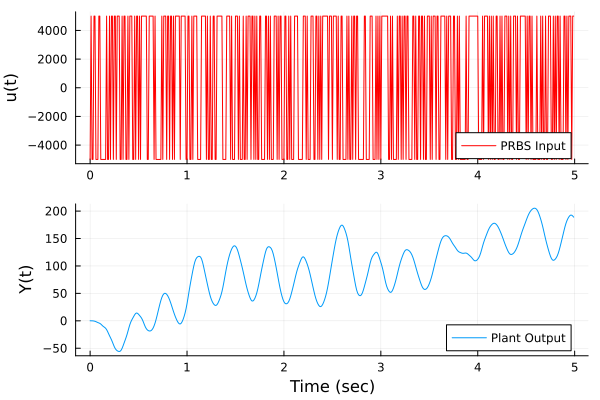

In [99]:
#Conduct Experiment
begin
    noise_level = 0.02 #random noise
    t_sim = collect(0:0.01:4.99)
    num_samples = size(t_sim,1)
    u_data = PRBS_generator(5000, num_samples) #Generate PRBS w/amplitude 2000
    u_data1 = reshape(u_data,(1,size(u_data)...))
    y_data, t_data, x_data = lsim(P, u_data1, t_sim, method=:zoh)
    y_data = dropdims(y_data,dims=1)
    ym_data = y_data .+ noise_level*rand(num_samples) #add noise to output
    u_plot = plot(t_data, u_data, label="PRBS Input", ylabel="u(t)", color=:red, legend=:bottomright)
    y_plot = plot(t_data, ym_data, label="Plant Output", xlabel="Time (sec)", ylabel="Y(t)", legend=:bottomright)
    plot(u_plot, y_plot, layout=(2,1))
end

In [136]:
#Model Estimation
begin
    Y = ym_data[8:490]
    X = zeros(483,14)
    for j in 1:483
        X[j,:] = [ -y_data[j+6] -y_data[j+5] -y_data[j+4] -y_data[j+3] -y_data[j+2] -y_data[j+1] -y_data[j] u_data[j+6] u_data[j+5] u_data[j+4] u_data[j+3] u_data[j+2] u_data[j+1] u_data[j]]
    end
end 
θ_LS = X\Y;

In [137]:
#Coeffs for Transfer Function
bₙ = [θ_LS[8] θ_LS[9] θ_LS[10] θ_LS[11] θ_LS[12] θ_LS[13] θ_LS[14]]
aₙ = [θ_LS[1] θ_LS[2] θ_LS[3] θ_LS[4] θ_LS[5] θ_LS[6] θ_LS[7]]

1×7 Matrix{Float64}:
 -2.40831  1.55163  0.593429  -1.08936  -0.359643  1.39919  -0.687018

In [146]:
#Generate Identified Discrete-time TF
begin
    Ts = 0.01
    z = tf("z", Ts)
    numz = bₙ[1]*z^6 + bₙ[2]*z^5 + bₙ[3]*z^4 + bₙ[4]*z^3 + bₙ[5]*z^2 + bₙ[6]*z + bₙ[7]
    denz = z^7 + aₙ[1]*z^6 + aₙ[2]*z^5 + aₙ[3]*z^4 + aₙ[4]*z^3 + aₙ[5]*z^2 + aₙ[6]*z + aₙ[7]
    Pz_lsid = numz/denz
end

TransferFunction{Discrete{Float64}, ControlSystemsBase.SisoRational{Float64}}
4.4378737688799397e-7z^6 + 6.889707246195377e-6z^5 + 2.5572952387925107e-5z^4 + 3.4694268349967366e-5z^3 + 2.150851244206851e-5z^2 + 5.134963137269537e-6z + 1.6205419276813605e-7
----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
     1.0z^7 - 2.4083064350400636z^6 + 1.5516253948401177z^5 + 0.5934288288809665z^4 - 1.0893583013789965z^3 - 0.35964263955264614z^2 + 1.399189328920152z - 0.68701759831655

Sample Time: 0.01 (seconds)
Discrete-time transfer function model

In [147]:
#Convert to CT TF
begin
    fz = -(s*Ts + 2)
    gz = (s*Ts - 2)
    
    nj = 7
    nums_id = bₙ[nj]gz^nj
    dens_id = fz^nj + aₙ[nj]gz^nj
    
    for j in 1:nj-1
        nums_id = nums_id + bₙ[j]*(fz^(nj-j))*(gz^j);
        dens_id = dens_id + aₙ[j]*(fz^(nj-j))*(gz^j);
    end
end

In [148]:
P_id = nums_id / dens_id

TransferFunction{Continuous, ControlSystemsBase.SisoRational{Float64}}
9.683676662174634e-21s^7 + 3.6638697890231324e-18s^6 + 1.2661237146787903e-15s^5 - 1.3270966358763995e-12s^4 - 1.1412831730671978e-9s^3 + 3.161329595195673e-7s^2 + 4.964351340860567e-5s - 0.0120839993770345
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
-5.722994266409566e-14s^7 - 2.261668016148831e-11s^6 - 3.0661784346184864e-8s^5 - 6.841813916471089e-7s^4 - 0.0004064549689365512s^3 - 0.0005451124897753734s^2 - 0.12047078518593768s + 0.010421970818583759

Continuous-time transfer function model

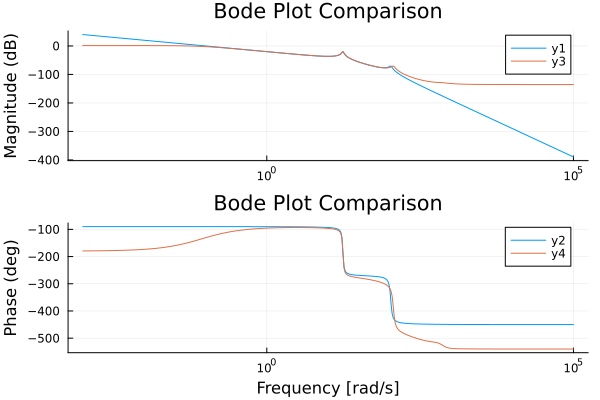

In [149]:
begin
    setPlotScale("dB")
    ω₁ = exp10.(LinRange(-2,3,2000))
    bodeplot([P, P_id], title="Bode Plot Comparison")
end

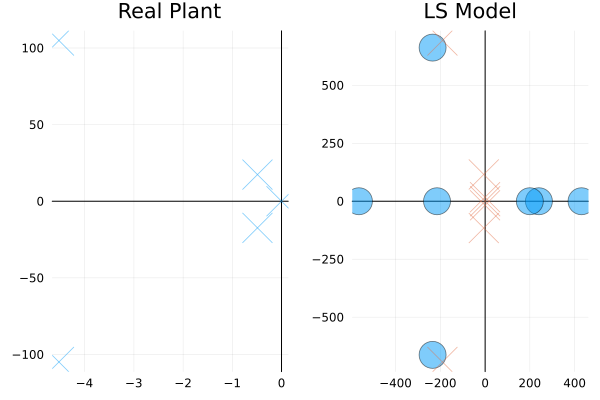

In [150]:
begin
    pzplot1 = pzmap(P, title="Real Plant")
    pzplot2 = pzmap(P_id, title="LS Model")
    plot(pzplot1, pzplot2, layout=(1,2))
end